In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B. 

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [2]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_collab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [3]:
using_colab = False

In [1]:
import os, argparse
from tqdm import tqdm
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
import cv2
import sys
sys.path.append("..")

import segmentation_models_pytorch as smp
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from dataset import PhenotypeDataset, train_augmentation, validation_augmentation, get_preprocessing

## Set-up

In [2]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

In [3]:
def load_sam(sam_checkpoint, model_type):
	#for now
	device = "cpu"

	sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
	sam.to(device=device)

	return SamAutomaticMaskGenerator(sam)

def visualize(total_rows, image, mask):
    plt.figure(figsize=(10,8))
    for i in range(total_rows):
        plt.subplot(total_rows,2,i*2+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(np.moveaxis(image, 0, -1))

        plt.subplot(total_rows,2,i*2+2)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(mask)

In [27]:
def preprocessing_fn(img, mask_gen=mask_generator, preprocess_resnet=preprocess_input):
    return preprocess_resnet(mask_gen.generate(img))

In [4]:
model_path = "../sam_vit_h_4b8939.pth"
model_type = "vit_h"
root_dir = "/Users/amankumar/Library/CloudStorage/OneDrive-UniversityofWaterloo/uWaterloo Courses/Winter '23/CS 679/Project/leaf_counting/Plant"
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

#Loading dataset

preprocess_input = smp.encoders.get_preprocessing_fn('resnet18', pretrained='imagenet')
mask_generator = load_sam(model_path, model_type)

## Example image

In [239]:
#!rm "/Users/amankumar/Library/CloudStorage/OneDrive-UniversityofWaterloo/uWaterloo Courses/Winter '23/CS 679/Project/leaf_counting/Plant/train/.DS_Store"
phenotype_dataset_train = PhenotypeDataset(root_dir=os.path.join(root_dir, 'train'), transform=train_augmentation())#, preprocessing=get_preprocessing(preprocessing_fn))
phenotype_dataset_test = PhenotypeDataset(root_dir=os.path.join(root_dir, 'test'), transform=validation_augmentation())#, preprocessing=get_preprocessing(preprocessing_fn))

batch_size = 4
train_dataloader = DataLoader(phenotype_dataset_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(phenotype_dataset_test, batch_size=32, shuffle=False)

In [233]:
sample = []
for i, data in enumerate(train_dataloader,0):
    sample.append(data['image'])

In [250]:
batch = 0
b = 0
for i, batch in tqdm(enumerate(train_dataloader, 0)):
    for b in batch['image']:
        print(b.shape)

2it [00:00,  7.10it/s]

torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])


3it [00:00,  7.36it/s]

torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])


8it [00:00,  8.31it/s]

torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])


11it [00:01,  8.27it/s]

torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])


13it [00:01,  9.59it/s]

torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])


15it [00:01,  7.50it/s]

torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])


17it [00:02,  6.39it/s]

torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])


19it [00:02,  5.94it/s]

torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])


23it [00:03,  7.67it/s]

torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])


26it [00:03,  9.15it/s]

torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])


31it [00:03, 16.86it/s]

torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])


39it [00:03, 20.03it/s]

torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])


43it [00:04, 20.14it/s]

torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])


46it [00:04, 12.30it/s]

torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])


50it [00:05, 10.92it/s]

torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])


52it [00:05,  8.85it/s]

torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])


54it [00:05,  7.50it/s]

torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])


57it [00:06,  7.30it/s]

torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])


61it [00:06,  9.42it/s]

torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])
torch.Size([320, 320, 3])


In [249]:
b

'image'

In [235]:
sample[0][0].shape

torch.Size([320, 320, 3])

In [218]:
img = sample[0][2]
img = img.numpy()

In [236]:
s = np.array([1,2,3,4,5,6,7,8])

In [238]:
s[s < 3]

array([1, 2])

In [220]:
masks = mask_generator.generate(img)

In [221]:
len(masks)

18

In [179]:
# image = cv2.imread('Plant/train/Ara2012/ara2012_plant004_label.png')
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [180]:
# image.shape

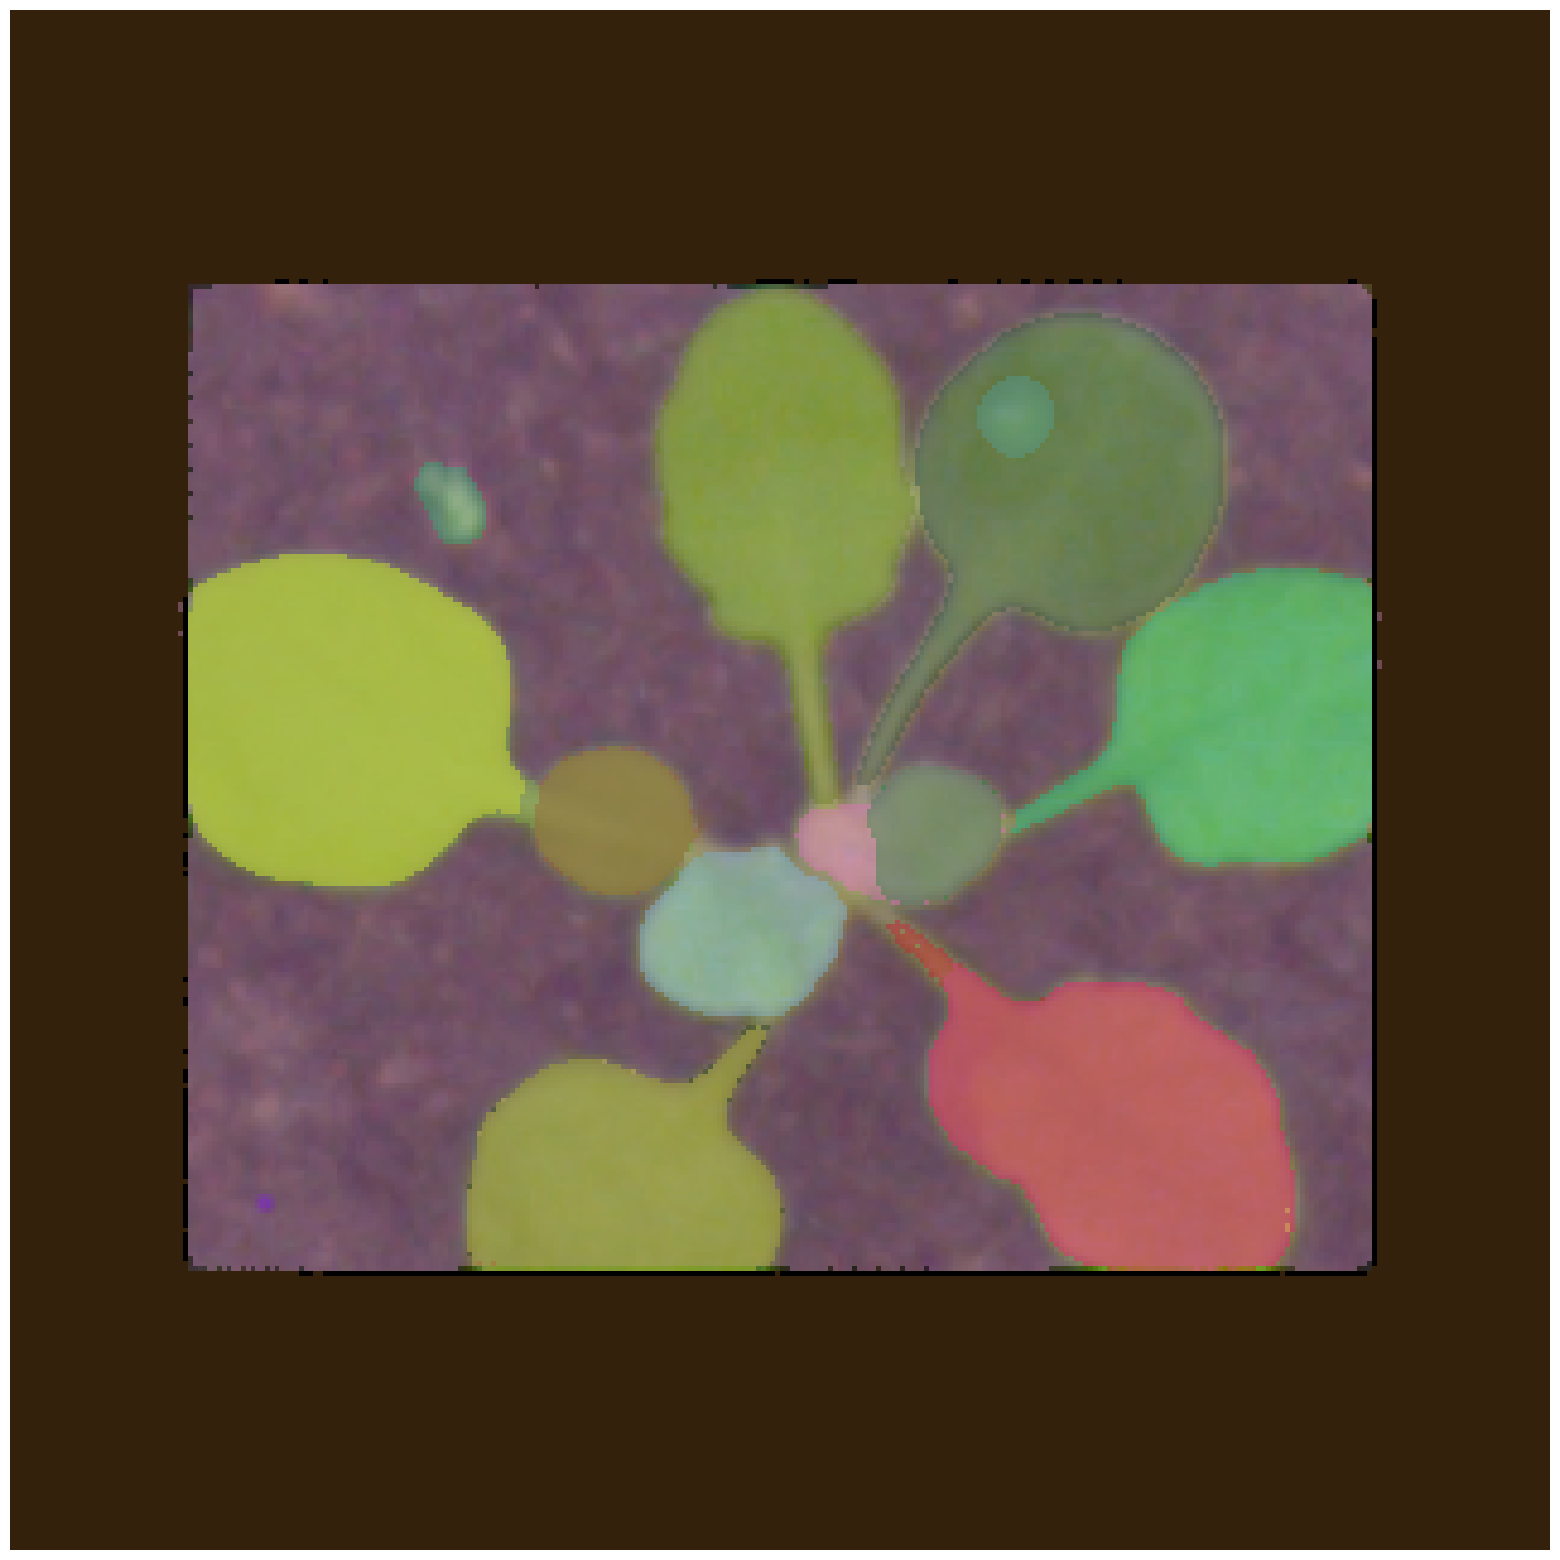

In [222]:
plt.figure(figsize=(20,20))
plt.imshow(img)
show_anns(masks)
plt.axis('off')
plt.show() 

In [223]:
sorted_masks = sorted(masks, key=(lambda x: x['area']), reverse=False)

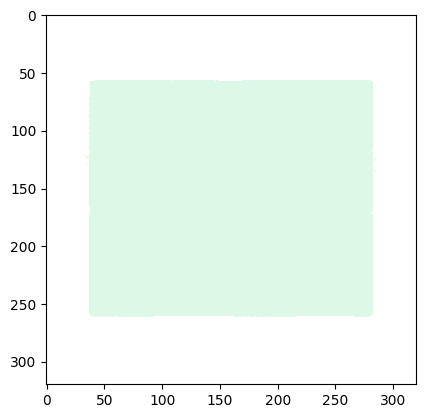

In [227]:
m = sorted_masks[len(sorted_masks)-2]['segmentation']
temp_img = np.ones((m.shape[0], m.shape[1], 3))
color_mask = np.random.random((1, 3)).tolist()[0]
for i in range(3):
    temp_img[:,:,i] = color_mask[i]
plt.imshow(np.dstack((temp_img, m*0.35)))

In [ ]:
m = masks[0]['segmentation']
temp_img = np.ones((m.shape[0], m.shape[1], 3), dtype=int)
color_mask = np.random.random((1, 3)).tolist()[0]
for i in range(3):
    temp_img[:,:,i] = int(round(color_mask[i]*255))
plt.imshow(np.dstack((temp_img, m*1)))

In [107]:
np.max(temp_img)

207

In [112]:
superimposed = np.where(np.repeat(m[:, :, np.newaxis], 3, axis=2), temp_img, img)

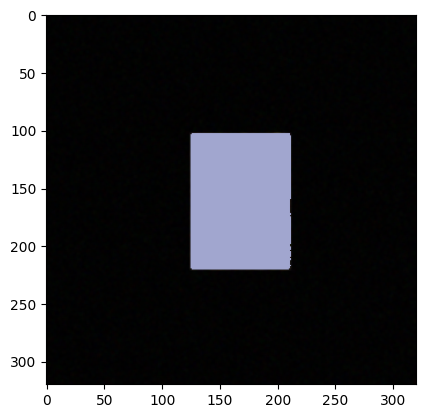

In [113]:
plt.imshow(superimposed)

In [228]:
superimposed = np.zeros((img.shape[0], img.shape[1], 3))
for mask in sorted_masks:
    m = mask['segmentation']
    print(mask["area"])
    temp_img = np.ones((m.shape[0], m.shape[1], 3))
    color_mask = np.random.random((1, 3)).tolist()[0]
    for i in range(3):
        temp_img[:,:,i] = color_mask[i]
    superimposed = np.where(np.repeat(m[:, :, np.newaxis], 3, axis=2), temp_img, superimposed)

184
209
627
814
865
1157
2446
2457
2988
3283
3528
3584
3609
3971
4822
4823
50235
51425


In [231]:
sorted_masks[-3]["area"]/sum([i["area"] for i in sorted_masks])

0.034199124990250095

In [ ]:
total_sum = sum([i["area"] for i in sorted_masks])
if sorted_masks[-1]["area"]/total_sum > 0.05:
    sorted_masks.pop(-1)
if sorted_masks[-1]["area"]/total_sum > 0.05:
    sorted_masks.pop(-1)

In [ ]:
superimposed = np.zeros((img.shape[0], img.shape[1], 3))
for mask in sorted_masks[0:-2]:
    m = mask['segmentation']
    print(mask["area"])
    temp_img = np.ones((m.shape[0], m.shape[1], 3))
    color_mask = np.random.random((1, 3)).tolist()[0]
    for i in range(3):
        temp_img[:,:,i] = color_mask[i]
    superimposed = np.where(np.repeat(m[:, :, np.newaxis], 3, axis=2), temp_img, superimposed)

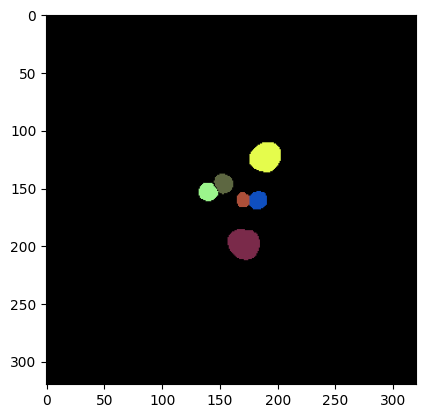

In [192]:
plt.imshow(superimposed)

In [61]:
#img = img.numpy()
img[masks[0]["segmentation"],masks[0]["segmentation"],masks[0]["segmentation"]].shape

IndexError: too many indices for array: array is 3-dimensional, but 6 were indexed

In [214]:
superimposed = np.zeros((img.shape[0], img.shape[1], 3))
            
for mask in sorted_masks[0:-2]:
    m = mask['segmentation']
    m = np.repeat(m[:, :, np.newaxis], 3, axis=2)*1.0
    print(mask["area"])
    color_mask = np.random.random((1, 3)).tolist()[0]
    for i in range(3):
        m[:,:,i] = m[:,:,i]*color_mask[i]
    superimposed = superimposed + m

122
202
211
223
560
594


In [215]:
np.max(m)

0.6979517181528788

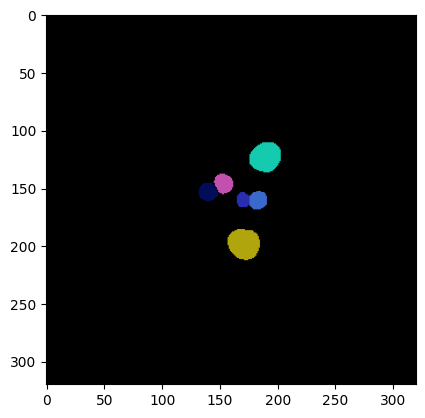

In [216]:
plt.imshow(superimposed)

In [54]:
masks[0]["segmentation"].shape

(320, 320)

In [60]:
len(mask)

1

In [23]:
phenotype_dataset_train

In [18]:
masks = mask_generator.generate(iter(phenotype_dataset_train))

AttributeError: 'iterator' object has no attribute 'shape'

In [31]:
for idx, batch in enumerate(train_dataloader):
        print(idx, batch['image'].size(), batch['count'].size())

        if idx == 3:
            plt.figure(figsize=(10,8))
            for i in range(batch['image'].shape[0]):
                plt.subplot(batch['image'].shape[0],2,i*2+1)
                plt.xticks([])
                plt.yticks([])
                plt.imshow(np.transpose(batch['image'][i].detach().cpu().numpy(), (1,2,0)))

                plt.subplot(batch['image'].shape[0],2,i*2+2)
                plt.xticks([])
                plt.yticks([])
                plt.imshow(batch['mask'][i].detach().cpu().numpy())
            
            plt.savefig('data.png')
            break

TypeError: preprocessing_fn() got an unexpected keyword argument 'cols'

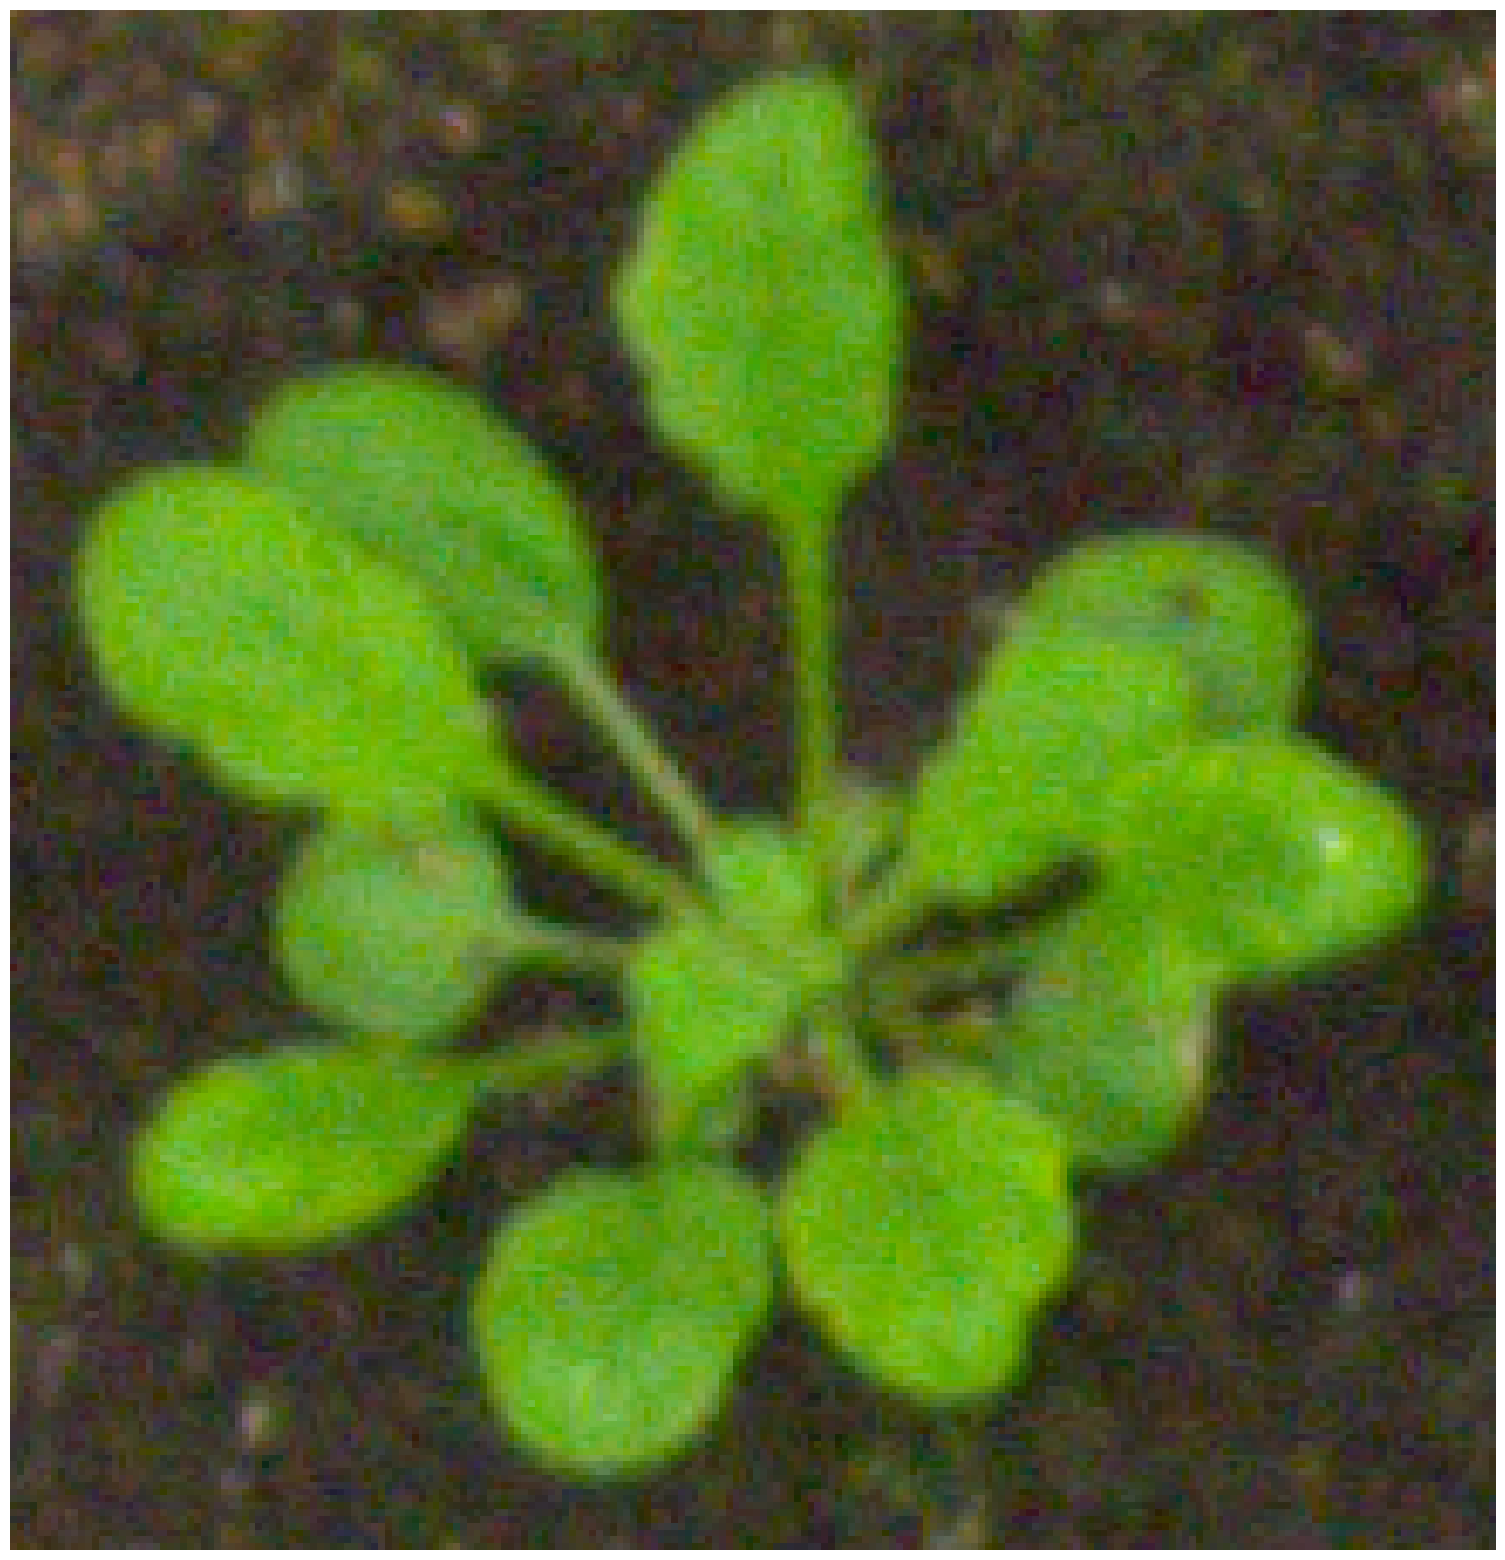

In [5]:
# plt.figure(figsize=(20,20))
# plt.imshow(image)
# plt.axis('off')
# plt.show()


## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [16]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "../../sam_vit_h_4b8939.pth"
model_type = "vit_h"

if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

#for now
device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run `generate` on an image.

In [17]:
masks = mask_generator.generate(image)

TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [8]:
print(len(masks))
print(masks[0].keys())

28
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Show all the masks overlayed on the image.

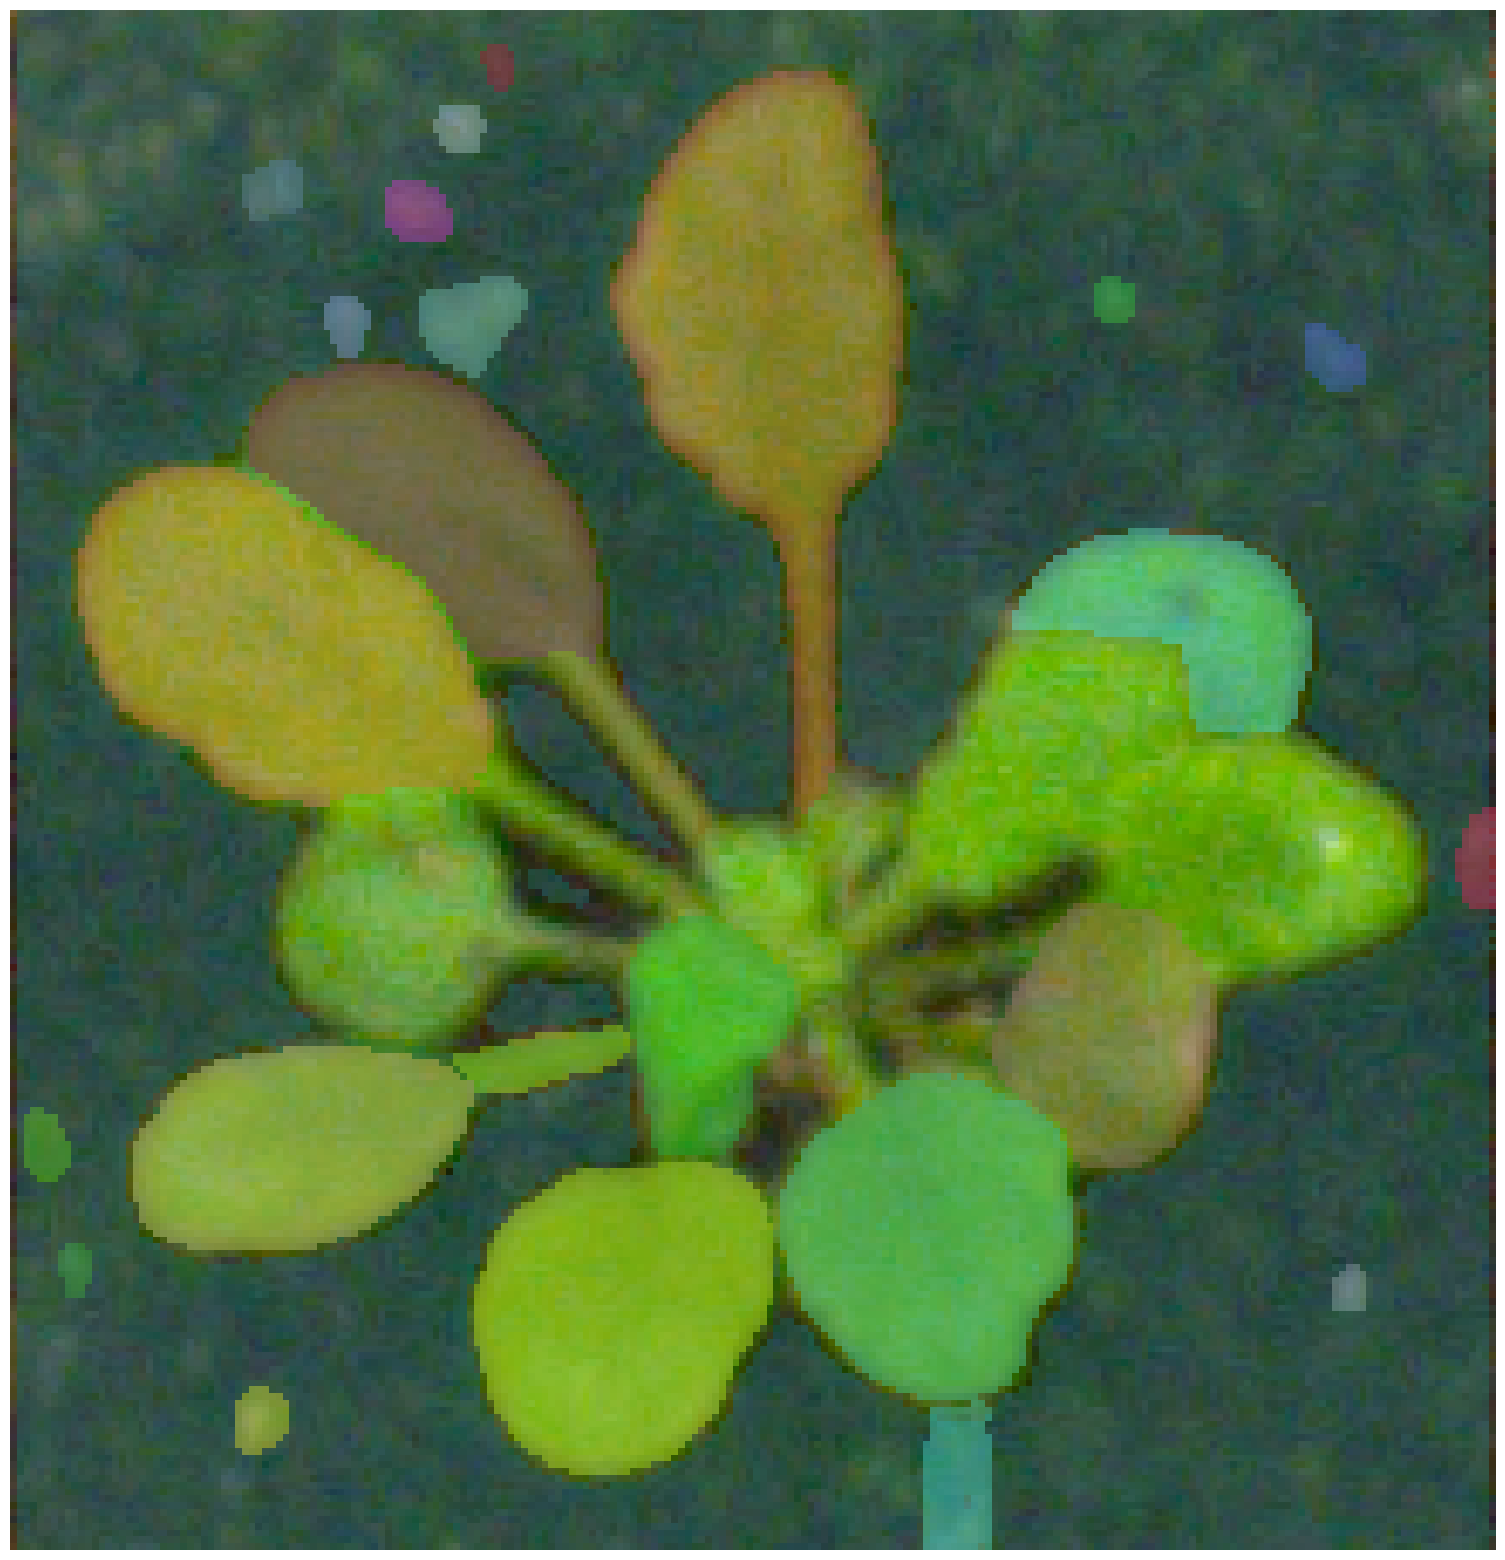

In [9]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [21]:
areas = []
for mask in masks:
    areas.append(mask["area"])

print(areas)

[28374, 1574, 1586, 2366, 780, 1175, 1341, 1545, 1339, 74, 164, 2106, 934, 66, 77, 33, 3157, 45, 630, 48, 27, 68, 31, 37, 65, 205, 161, 60]


In [27]:
areas.remove(28374)

(array([14.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  2.,  3.,  0.,  0.,  0.,
         1.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([  27. ,  183.5,  340. ,  496.5,  653. ,  809.5,  966. , 1122.5,
        1279. , 1435.5, 1592. , 1748.5, 1905. , 2061.5, 2218. , 2374.5,
        2531. , 2687.5, 2844. , 3000.5, 3157. ]),
 <BarContainer object of 20 artists>)

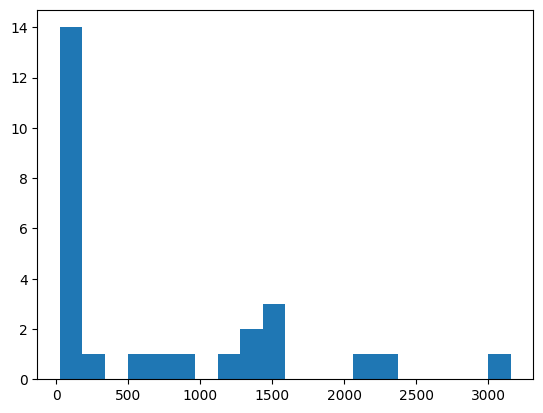

In [28]:
plt.hist(areas, bins = 20)

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [24]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [25]:
masks2 = mask_generator_2.generate(image)

In [26]:
len(masks2)

90

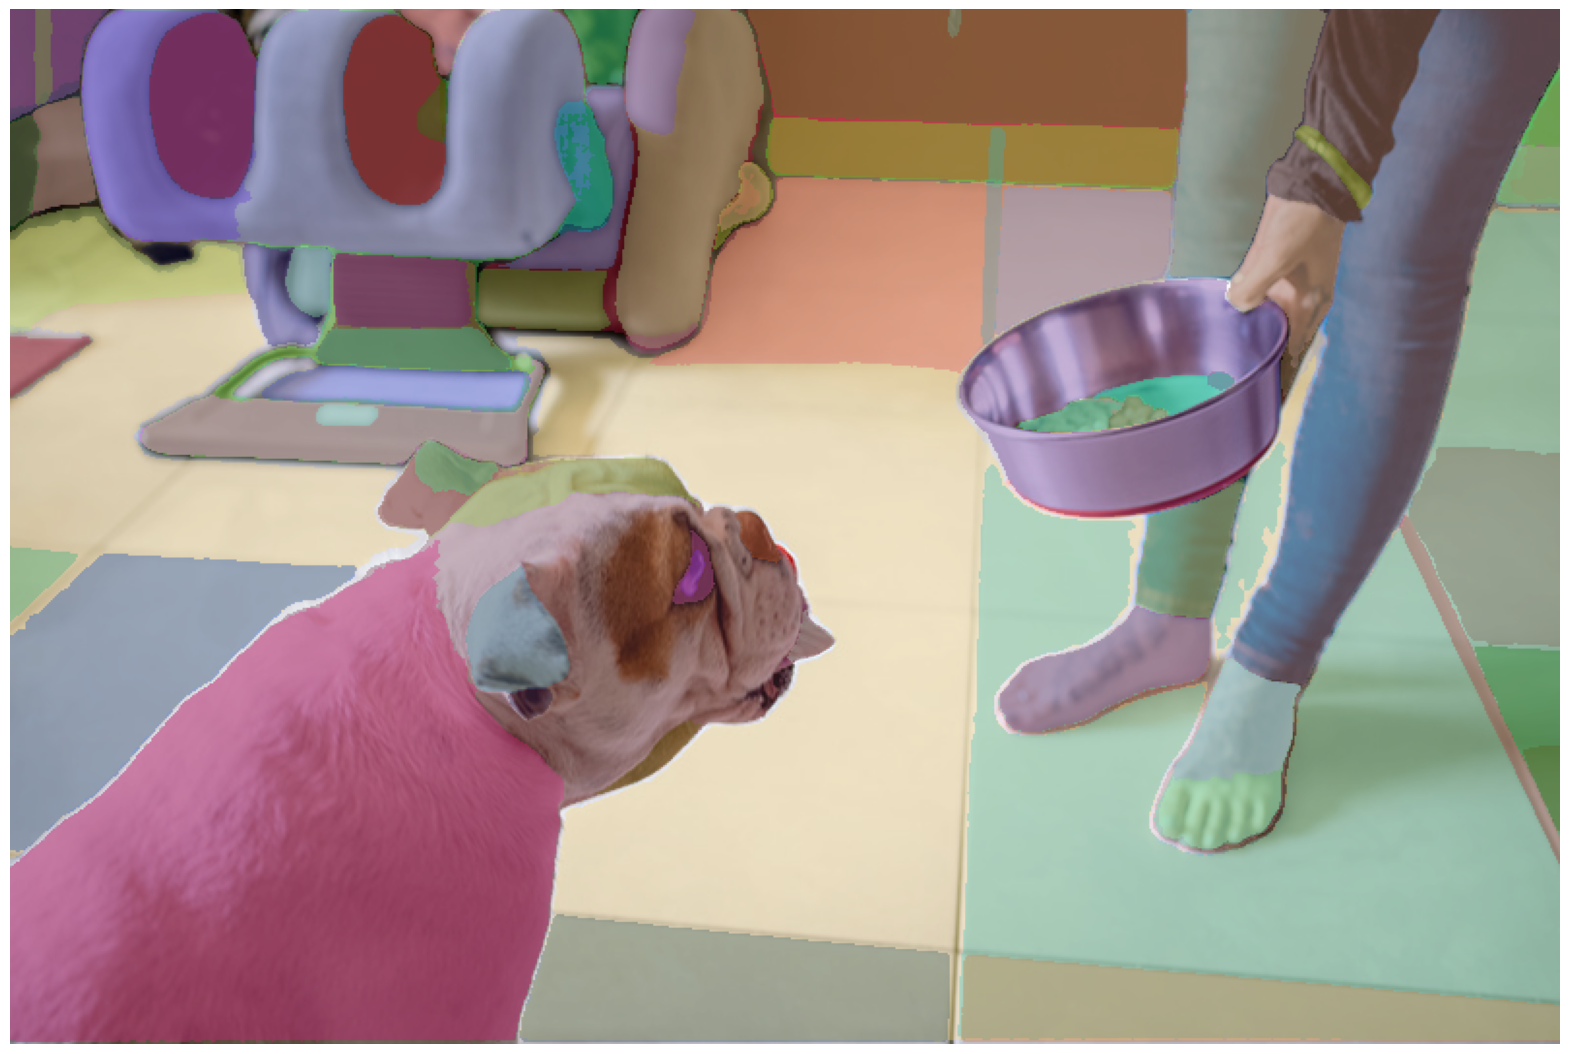

In [27]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 